# Topic Modeling by LDA Model
---

At this notebook you can find realization of classification task by means of topic modeling. We will try to determine `N_MOST_POPULAR` topics according to `N_MOST_POPULAR` tags and then will try to connect topics and tags by probabilities.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import json

In [2]:
module_path = os.path.abspath(os.path.join('..\..')) # Path to root folder
if module_path not in sys.path:
    sys.path.append(module_path + "/scripts") # define scripts path

from ipynb_func import *

Data loader:

In [3]:
NUM = 10 # Number of data parquets to use
assert NUM >= 1 and NUM <= 10, "NUM value must be in range [1, 10]"

# Making list of roots to merge processed raw data 
#paths = [module_path + f"/data/pikabu/tag_processed/raw_data/{i}_tag_processed.parquet" for i in range(NUM)] 

# Making list of roots to merge processed filtered data
#paths = [module_path + f"/data/pikabu/tag_processed/filtered_data/{i}_tag_processed.parquet" for i in range(NUM)] 

# Making list of roots to merge processed cleared data
paths = [module_path + f"/data/pikabu/splited_data/cleared_texts_old.parquet"] 

data = merge_dataset(paths)

---
### 0. Quick data analysis.

Quick look at the dataset:

In [4]:
pd.set_option('display.max_colwidth', 180)
data.head(3)

,id,text_markdown,tags
15,6991359,"[добрый, сутки, господин, дама, подсказывать, название, игра, телефон, оформление, убийство, зомби, очки, ездить, машинка, крутить, развивать, скорость, заранее, благодарить]","[Игры, Поиск]"
37,7004423,"[ехать, девчонка, школа, оставаться, свободный, макс, заявка, прямой, конечный, адрес, железнодорожный, институт, включать, вбивать, адрес, выдавать, столовая, ладно, садиться,...",[Юмор]
52,6991603,"[стадо, стадо, гигантский, случаться, стадо, управлять, волк, предел, волк, жопа, враг, дружно, осматривать, выдавливать, стадо, выдавливать, съедать, волк, близкий, холм, обхо...",[Мат]


Prepare our data for training and validating, testing. We'll split our dataset in accordance with json file, which describes id of the posts and their corresponding division into groups.

In [5]:
with open(module_path + f"/data/pikabu/splited_data/indexes.json") as f:
    id_splits = f.read()

id_splits = json.loads(id_splits)

data_train = data[data['id'].isin(id_splits['train'])]
data_test = data[data['id'].isin(id_splits['test'])]
data_val = data[data['id'].isin(id_splits['val'])]

In [6]:
data_val.head(2)

,id,text_markdown,tags
421,6992880,"[популярный, пк, игра, создавать, устройство, проходить, картинка, память, оставаться, различный, создавать, написать, догадка, дикий, желание, проходить]",[Помогите найти]
432,6992917,"[профессия, оказываться, сопровождать, образование, курсы, обязанность, входить, хотеться, разговор, зажигать, свеча, оказываться, нарушение, род, кодекс, общий, тысяча, цена, ...",[Психология]


Now we going to define a-priori distribution of tags in our dataset. We can use it to teach our LDA model according to our data.

In [7]:
topics_dict = getworddict(getwordlist(data.tags))
topic_distribution = []
topic_code = {}

total_tags = sum(topics_dict.values())

for enum, name in enumerate(topics_dict):
    topic_code[enum] = name
    topic_distribution.append(topics_dict[name]/total_tags)

At the same time, let's count the number of topics to predict:

In [8]:
num_topics = len(topic_distribution)
print('Number of topics to predict:', num_topics)

Number of topics to predict: 60


Data is ready, we can go further.

---
## 1. Model training

In this section, we describe and train LDA model for the topic classification task through topic modeling. 

In [9]:
from gensim.models.ldamodel import LdaModel, CoherenceModel
from gensim.corpora.dictionary import Dictionary

We need to make dictionary out of all dataset to create bag-of-words, which is used by LDA model to calculate dependencies. So, we also create train/val/test corpuses by created dictionary.

In [10]:
data_text = [t.tolist() for t in data.text_markdown]
dict = Dictionary(data_text)
corpus = [dict.doc2bow(text) for text in data_text]

train_data_text = [t.tolist() for t in data_train.text_markdown]
train_corpus = [dict.doc2bow(text) for text in train_data_text]

val_data_text = [t.tolist() for t in data_val.text_markdown]
val_corpus = [dict.doc2bow(text) for text in val_data_text]

test_data_text = [t.tolist() for t in data_test.text_markdown]
test_corpus = [dict.doc2bow(text) for text in test_data_text]

Model configuration:

In [11]:
np.random.seed(42)

lda_cfg = {'num_topics': num_topics,
           'epochs': 15,
           'chunksize': 100,
           'update_every': 10,
           'alpha': topic_distribution, # we can use our initial topic distribution to teach our algorithm
           #'alpha': 'auto',
           'eta': 'auto',
           'random_state': 42}

Train model or load already trained model to recalculate some parameters:

In [12]:
#a = input('Do you want to train new model? (Y for yes)')
a = 'n'
if a == 'Y':
    print('Training new model...')
    LDA = LdaModel(corpus=train_corpus,
                id2word=dict,
                num_topics=lda_cfg['num_topics'],
                passes=lda_cfg['epochs'],
                chunksize=lda_cfg['chunksize'],
                update_every=lda_cfg['update_every'],
                alpha=lda_cfg['alpha'],
                eta=lda_cfg['eta'],
                random_state=lda_cfg['random_state'])
else:
    #model_name = input('Write model name to load:')
    model_name = 'filtered_lda_model'
    model_path = module_path + '/models/lda/' + model_name
    LDA = LdaModel.load(model_path + '.model')
    print(f'Loaded model: {model_name}')

Loaded model: filtered_lda_model


Working model result:

In [13]:
LDA.show_topics(num_topics=5, formatted=True)

[(50,
  '0.154*"андрей" + 0.075*"миша" + 0.071*"газ" + 0.065*"максим" + 0.056*"мастер" + 0.049*"ольга" + 0.033*"макс" + 0.029*"заебывать" + 0.027*"газовый" + 0.024*"бла"'),
 (41,
  '0.085*"охранник" + 0.048*"желательно" + 0.036*"здание" + 0.035*"кол" + 0.035*"камень" + 0.031*"зеркало" + 0.028*"сибирь" + 0.027*"миф" + 0.027*"военкомат" + 0.027*"психиатр"'),
 (11,
  '0.032*"коронавирус" + 0.026*"муж" + 0.015*"подруга" + 0.013*"месяц" + 0.012*"приезжать" + 0.012*"общаться" + 0.009*"неделя" + 0.009*"знакомый" + 0.008*"общий" + 0.008*"уезжать"'),
 (49,
  '0.052*"пост" + 0.024*"сайт" + 0.023*"читать" + 0.018*"пикабу" + 0.017*"написать" + 0.016*"http" + 0.015*"интернет" + 0.013*"интересный" + 0.013*"ссылка" + 0.013*"комментарий"'),
 (22,
  '0.012*"проблема" + 0.008*"ситуация" + 0.008*"мысль" + 0.007*"любой" + 0.006*"происходить" + 0.006*"отношение" + 0.005*"пытаться" + 0.005*"возможно" + 0.005*"чувство" + 0.005*"хотеться"')]

And now we calculate some of model's metrics:

In [14]:
print('Perplexity of a model:', LDA.log_perplexity(val_corpus))

Perplexity of a model: -10.411881313189022


In [15]:
coher = CoherenceModel(model=LDA, texts=val_data_text, dictionary=dict, coherence='c_v')
#coher_lda = coher.get_coherence()
#print('Coherence of a model:', coher_lda)

In [16]:
top = LDA.top_topics(corpus=val_corpus)
coh = []
for topic in top:
    for word in topic[0]:
        coh.append(word[0])
coh = np.mean(coh)

print('Mean coherence of a words: ', coh)

Mean coherence of a words:  0.017025884


Save model for future use:

In [17]:
#a = input('Are you sure, that you want to save the model? (Y/n)')
a = 'n'
if a == 'Y':
    model_path = module_path + '/models/lda/'
    name = input('Name your model:')
    LDA.save(model_path + name + '.model')

---
## 2. LDA model's analysis

In this section, we will analyze the resulting model and try to match the topics of the model with the existing tags of the dataset.

We trained a few model's, and let's take a look for two of them.

First model to see -- model with "auto" a-priori distribution learner in LDA model.

In [18]:
model_name = 'filtered_lda_model'
model_path = module_path + '/models/lda/' + model_name
LDA = LdaModel.load(model_path + '.model')

Let's assign the numbers of the most likely predicted topics to the posts in the dataset, the probability of which exceeds the `THRESHOLD`:

In [19]:
THRESHOLD = 0.1

def get_corpus_topics(model, corpus, thr=THRESHOLD):
    corpus_topics = []
    for sentence in test_corpus:
        topics = LDA.get_document_topics(sentence)
        topics = sorted(topics, key=lambda x: x[1], reverse=True)
        topics_for_sentence = []
        for i in range(len(topics)):
            if topics[i][1] > thr:
                topics_for_sentence.append(topics[i][0])
        corpus_topics.append(topics_for_sentence) 
    return corpus_topics

As the result, we have following data:

In [20]:
test_filtered_model = data_test.copy()
test_filtered_model['corpus_topics'] = get_corpus_topics(LDA, test_corpus)

test_filtered_model.head(3)

,id,text_markdown,tags,corpus_topics
163,7163939,"[ширина, полоса, использоваться, житель, парковка, непосредственно, дома, стараться, ставить, житель, поздно, приезжать, приходиться, ставить, метр, дома, естественно, страшный...",[Соседи],"[18, 43, 20]"
181,7291034,"[написать, декабрь, заказывать, полный, профиль, инстаграм, сайт, профиль, инстаграм, сайт, выглядеть, выглядеть, заплатить, приличный, сумма, оплачивать, услуга, переделывать,...",[Мат],"[8, 5]"
242,6992860,"[многие, водитель, сталкиваться, пассажир, заезжать, платить, вспомнить, садиться, девушка, заезжать, магазин, кнопка, ожидание, вводить, поменять, конечный, адрес, жалко, борщ...",[Мат],"[18, 5]"


Look at topics distribution of `model_name` topics:

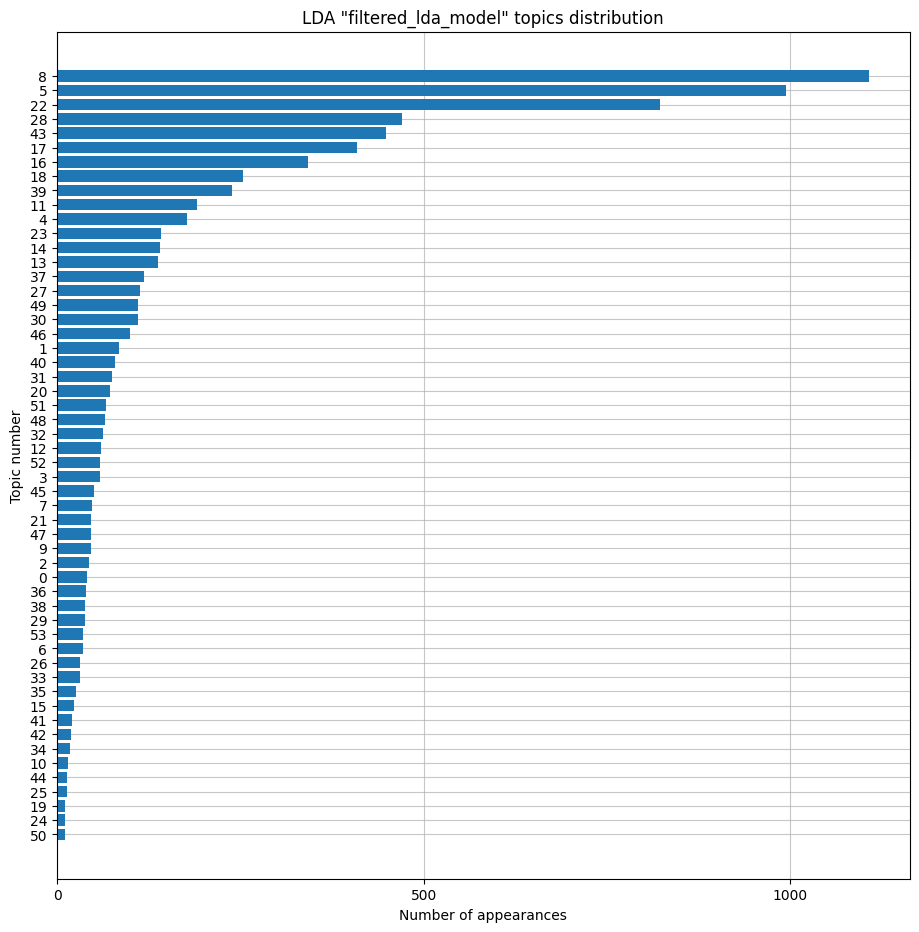

In [21]:
corp = getworddict(getwordlist(test_filtered_model.corpus_topics), reverse=False)
corp_w = list(map(str, corp.keys()))
corp_c = list(corp.values())

raw_fig, ax = plt.subplots(figsize=(11, 11))

ax.grid(zorder=1, alpha=0.7)
ax.barh(corp_w, corp_c, zorder=2)
ax.set_xticks(np.arange(0, max(corp_c), 500))
ax.set_xlabel("Number of appearances")
ax.set_ylabel("Topic number")
ax.set_title(f"LDA \"{model_name}\" topics distribution");

Based on this distribution, we will assume that the topics in the model are distributed approximately the same as the tags in the data (if we look at the graphs in `dataset_tag_analysis.ipynb`, there are actually similarities). So, we will assign a tag name to each topic in the model in accordance with the distributions (that is, we will sort in descending order the frequency of use of tags and model topics and assign a tag to the corresponding topic):

In [22]:
topic_names = {}
for topic_id, topic_name in zip(corp.keys(), topics_dict.keys()):
    topic_names[topic_id] = topic_name

As the result, we have the following:

In [23]:
new_topics = [[topic_names[topic_id] for topic_id in topic] for topic in test_filtered_model.corpus_topics]
data_copy_fm = test_filtered_model.copy()
data_copy_fm.corpus_topics = new_topics

In [24]:
data_copy_fm.head(2)

,id,text_markdown,tags,corpus_topics
163,7163939,"[ширина, полоса, использоваться, житель, парковка, непосредственно, дома, стараться, ставить, житель, поздно, приезжать, приходиться, ставить, метр, дома, естественно, страшный...",[Соседи],"[Музыка, Анекдот, Кот]"
181,7291034,"[написать, декабрь, заказывать, полный, профиль, инстаграм, сайт, профиль, инстаграм, сайт, выглядеть, выглядеть, заплатить, приличный, сумма, оплачивать, услуга, переделывать,...",[Мат],"[Алкоголь, Санкт-Петербург]"


Calculate `recall@k`:

In [25]:
K = 5
lda_recallk_fm_mean, lda_recallk_fm_med = recallk(data_copy_fm.tags, data_copy_fm.corpus_topics, k=K)
print(f'\'{model_name}\' model\'s mean recall@k: {lda_recallk_fm_mean:.4f}')

'filtered_lda_model' model's mean recall@k: 0.0280


Let's check another model, where we put a-priori distribution of topics in a model:

In [26]:
model_name = 'cleared_data_model'
model_path = module_path + '/models/lda/' + model_name
LDA = LdaModel.load(model_path + '.model')

And see which topic tags it will give us:

In [27]:
test_cleared_model = data_test.copy()
test_cleared_model['corpus_topics'] = get_corpus_topics(LDA, test_corpus)

test_cleared_model.head(3)

,id,text_markdown,tags,corpus_topics
163,7163939,"[ширина, полоса, использоваться, житель, парковка, непосредственно, дома, стараться, ставить, житель, поздно, приезжать, приходиться, ставить, метр, дома, естественно, страшный...",[Соседи],"[30, 36, 32]"
181,7291034,"[написать, декабрь, заказывать, полный, профиль, инстаграм, сайт, профиль, инстаграм, сайт, выглядеть, выглядеть, заплатить, приличный, сумма, оплачивать, услуга, переделывать,...",[Мат],"[45, 34, 55, 29]"
242,6992860,"[многие, водитель, сталкиваться, пассажир, заезжать, платить, вспомнить, садиться, девушка, заезжать, магазин, кнопка, ожидание, вводить, поменять, конечный, адрес, жалко, борщ...",[Мат],"[11, 55, 47]"


Distribution of topics:

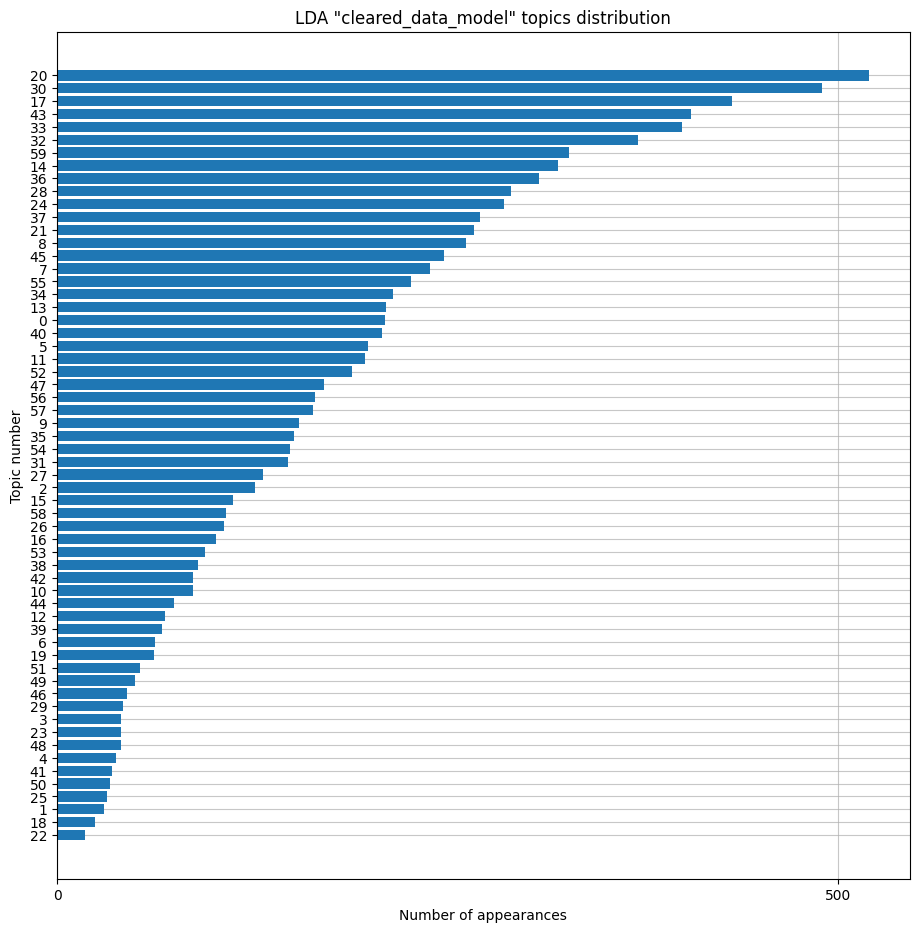

In [28]:
corp = getworddict(getwordlist(test_cleared_model.corpus_topics), reverse=False)
corp_w = list(map(str, corp.keys()))
corp_c = list(corp.values())

raw_fig, ax = plt.subplots(figsize=(11, 11))

ax.grid(zorder=1, alpha=0.7)
ax.barh(corp_w, corp_c, zorder=2)
ax.set_xticks(np.arange(0, max(corp_c), 500))
ax.set_xlabel("Number of appearances")
ax.set_ylabel("Topic number")
ax.set_title(f"LDA \"{model_name}\" topics distribution");

As suposed, it is similar to initial distiribution of tags in dataset (obviously, because we point it directly). So, continue further as previous:

In [29]:
topic_names = {}
for topic_id, topic_name in zip(corp.keys(), topics_dict.keys()):
    topic_names[topic_id] = topic_name

As the result:

In [30]:
new_topics = [[topic_names[topic_id] for topic_id in topic] for topic in test_cleared_model.corpus_topics]
data_copy_cm = test_cleared_model.copy()
data_copy_cm.corpus_topics = new_topics

In [31]:
data_copy_cm.head(2)

,id,text_markdown,tags,corpus_topics
163,7163939,"[ширина, полоса, использоваться, житель, парковка, непосредственно, дома, стараться, ставить, житель, поздно, приезжать, приходиться, ставить, метр, дома, естественно, страшный...",[Соседи],"[Bash im, Врачи, Авто]"
181,7291034,"[написать, декабрь, заказывать, полный, профиль, инстаграм, сайт, профиль, инстаграм, сайт, выглядеть, выглядеть, заплатить, приличный, сумма, оплачивать, услуга, переделывать,...",[Мат],"[Родители и дети, Истории, Армия, Россия]"


Calculate `recall@k`:

In [32]:
lda_recallk_cm_mean, lda_recallk_cm_med = recallk(data_copy_cm.tags, data_copy_cm.corpus_topics, k=K)
print(f'\'{model_name}\' model\'s mean recall@k: {lda_recallk_cm_mean:.4f}')

'cleared_data_model' model's mean recall@k: 0.0268


Thus, we can say that either the assumption turned out to be incorrect (╯°□°）╯︵ ┻━┻.

---
## 3. Another last aproach

For the final time, let's try to compare tags in dataset with topics of a model by hands. We have 60 tags, so it's not very time consuming.

There we will use model with preset a-priori distribution.

In [33]:
model_name = 'cleared_data_model'
model_path = module_path + '/models/lda/' + model_name
LDA = LdaModel.load(model_path + '.model')

In [34]:
data_forhand = data_test.copy()
data_forhand['corpus_topics'] = get_corpus_topics(LDA, test_corpus, thr=0.15)

data_forhand.head(3)

,id,text_markdown,tags,corpus_topics
163,7163939,"[ширина, полоса, использоваться, житель, парковка, непосредственно, дома, стараться, ставить, житель, поздно, приезжать, приходиться, ставить, метр, дома, естественно, страшный...",[Соседи],"[30, 36, 32]"
181,7291034,"[написать, декабрь, заказывать, полный, профиль, инстаграм, сайт, профиль, инстаграм, сайт, выглядеть, выглядеть, заплатить, приличный, сумма, оплачивать, услуга, переделывать,...",[Мат],"[45, 34]"
242,6992860,"[многие, водитель, сталкиваться, пассажир, заезжать, платить, вспомнить, садиться, девушка, заезжать, магазин, кнопка, ожидание, вводить, поменять, конечный, адрес, жалко, борщ...",[Мат],"[11, 55]"


Let's use pyLDAvis for visuallization of `model_name` LDA model:

In [35]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim.prepare(LDA, test_corpus, dict)
vis_data

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.095907 -0.149550       1        1  5.637339
33     0.218689  0.017448       2        1  5.303212
36     0.161720 -0.104508       3        1  5.144577
20     0.181319 -0.094715       4        1  4.584226
30     0.041154 -0.220276       5        1  4.537921
59    -0.210656 -0.156914       6        1  3.403533
28     0.206338  0.049353       7        1  3.295297
7     -0.036749 -0.085349       8        1  3.263546
32     0.153205 -0.054103       9        1  3.220071
37    -0.263722 -0.022036      10        1  2.956606
14     0.038836 -0.212896      11        1  2.909582
13     0.136334 -0.026223      12        1  2.871595
24     0.156140  0.009886      13        1  2.520945
21    -0.204914 -0.033874      14        1  2.319119
34    -0.118698 -0.063751      15        1  2.095269
0      0.060015 -0.127941      16        1  1.966893
40    -0.079211 -0.101922      17        1  1.966532
55    -0.036658 -0.068782      18        1  1.764764
58     0.054962  0.042733      19        1  1.719887
5      0.021659 -0.175673      20        1  1.677466
43    -0.051413 -0.159556      21        1  1.564988
57    -0.234347  0.047586      22        1  1.545265
56     0.178961  0.073780      23        1  1.431626
52     0.081359 -0.068555      24        1  1.420236
9     -0.026482 -0.088720      25        1  1.404589
11     0.095530  0.009754      26        1  1.375323
47    -0.024347 -0.053324      27        1  1.364143
45    -0.110990 -0.109493      28        1  1.346955
15     0.184645  0.022957      29        1  1.315184
35    -0.011258 -0.006252      30        1  1.304946
31     0.106855  0.032896      31        1  1.286249
8      0.024525 -0.097050      32        1  1.280317
54     0.088415 -0.092044      33        1  1.231034
42    -0.033632  0.080332      34        1  1.148678
27     0.121452  0.061477      35        1  1.106998
53    -0.200890  0.073891      36        1  1.067440
12    -0.024361  0.084061      37        1  1.034810
44    -0.086295 -0.122567      38        1  0.946304
19    -0.084431  0.136742      39        1  0.922766
10    -0.043327 -0.010115      40        1  0.906376
2      0.015505 -0.039529      41        1  0.852277
38     0.001810  0.048869      42        1  0.852238
39     0.024944  0.099543      43        1  0.837318
6     -0.077618  0.033348      44        1  0.789312
16     0.057661  0.067837      45        1  0.783219
4     -0.063606  0.027764      46        1  0.684006
26     0.043624  0.018367      47        1  0.624229
1      0.044143  0.152194      48        1  0.600890
46    -0.001551  0.113621      49        1  0.580707
51     0.010271  0.151400      50        1  0.563984
29    -0.026253  0.069601      51        1  0.553153
25    -0.030120  0.123069      52        1  0.526229
41    -0.096316  0.071263      53        1  0.513733
3     -0.012230  0.064906      54        1  0.512055
50    -0.039685  0.086039      55        1  0.479049
48    -0.086018  0.057542      56        1  0.468899
18     0.059578  0.151020      57        1  0.460771
23     0.016736  0.118649      58        1  0.429751
22    -0.124134  0.175341      59        1  0.373613
49    -0.050567  0.172449      60        1  0.351960, topic_info=          Term        Freq       Total Category  logprob  loglift
396    девушка  817.000000  817.000000  Default  30.0000  30.0000
519       мама  758.000000  758.000000  Default  29.0000  29.0000
141     парень  517.000000  517.000000  Default  28.0000  28.0000
692    мужчина  451.000000  451.000000  Default  27.0000  27.0000
17     телефон  474.000000  474.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
3622      роль   10.427668   74.453756  Topic60  -4.6762   3.6837
3003   картина   14.661594  126.488030  Topic60  -4.3354   3.4945
898    снимать   24.088116  285.995983  Topic60  -3.8389   3.1751
659   качес

And let's get tags, we need to compare:

In [36]:
print('Tags to compare with topics:')
print('===========')
for i, word in enumerate(topic_code.values()):
    if i != 59:
        print(word, end=', ')
    else:
        print(word)
    if i % 5 == 0 and i != 0:
        print()
print('===========')

Tags to compare with topics:
Мат, Помощь, Коронавирус, Юмор, История, Реальная история из жизни, 
Политика, Рассказ, Работа, Дети, Россия, 
Украина, Стихи, Общество, Другое, Отношения, 
Вопрос, Жизнь, Новости, Любовь, Негатив, 
Семья, Школа, Карантин, Девушки, Медицина, 
Игры, Интересное, Случай из жизни, Авторский рассказ, Психология, 
Кот, Помогите найти, Фантастика, Детство, Книги, 
Фильмы, Лига Добра, Москва, Мысли, Деньги, 
Соседи, Истории, Армия, Люди, Родители и дети, 
Музыка, Ищу фильм, Новый Год, Анекдот, Совет, 
Врачи, Санкт-Петербург, Алкоголь, Авто, Поиск, 
Сон, Самоизоляция, Bash im, Новый год


In the result of manual labeling, we have the following:

In [37]:
hand_code_LDAvis = {1: "Фантастика",
             2: "История",
             3: "Лига Добра",
             4: "Жизнь",
             5: "Отношения",
             6: "Общество",
             7: "Детство",
             8: "Медицина, Врачи",
             9: "Другое",
             10: "Россия",
             11: "Стихи",
             12: "Рассказ",
             13: "Семья",
             14: "Украина",
             15: "Деньги",
             16: "Мат",
             17: "Работа",
             18: "Другое",
             19: "Авторский рассказ",
             20: "Психология",
             21: "Совет",
             22: "Политика",
             23: "Соседи",
             24: "Любовь",
             25: "Школа",
             26: "Авто",
             27: "Помогите найти",
             28: "Другое",
             29: "Сон",
             30: "Карантин",
             31: "Новый Год",
             32: "Книги",
             33: "Негатив",
             34: "Армия",
             35: "Другое",
             36: "Новости",
             37: "Работа",
             38: "Работа",
             39: "Интересное",
             40: "Другое",
             41: "Семья",
             42: "Музыка",
             43: "Алкоголь",
             44: "Другое",
             45: "Девушки",
             46: "Другое",
             47: "Игры",
             48: "Случай из жизни",
             49: "Мысли",
             50: "Другое",
             51: "Истории",
             52: "Реальная история из жизни",
             53: "Другое",
             54: "Другое",
             55: "Мат",
             56: "Другое",
             57: "Люди",
             58: "Новый Год",
             59: "Bash im",
             60: "Ищу фильм"}

hand_code = {(i-1):t for i, t in zip(vis_data.topic_order, hand_code_LDAvis.values())}

In [38]:
new_fh_topics = [[hand_code[topic_id] for topic_id in topic] for topic in data_forhand.corpus_topics]
data_fh_copy = data_forhand.copy()
data_fh_copy.corpus_topics = new_fh_topics

In [39]:
data_fh_copy.head(3)

,id,text_markdown,tags,corpus_topics
163,7163939,"[ширина, полоса, использоваться, житель, парковка, непосредственно, дома, стараться, ставить, житель, поздно, приезжать, приходиться, ставить, метр, дома, естественно, страшный...",[Соседи],"[Отношения, Лига Добра, Другое]"
181,7291034,"[написать, декабрь, заказывать, полный, профиль, инстаграм, сайт, профиль, инстаграм, сайт, выглядеть, выглядеть, заплатить, приличный, сумма, оплачивать, услуга, переделывать,...",[Мат],"[Другое, Деньги]"
242,6992860,"[многие, водитель, сталкиваться, пассажир, заезжать, платить, вспомнить, садиться, девушка, заезжать, магазин, кнопка, ожидание, вводить, поменять, конечный, адрес, жалко, борщ...",[Мат],"[Авто, Другое]"


Calculate `recall@k`:

In [40]:
lda_recallk_fh_mean, lda_recallk_fh_med = recallk(data_fh_copy.tags, data_fh_copy.corpus_topics)
print(f'Mean recall@k with manual labeling: {lda_recallk_fh_mean:.4f}')

Mean recall@k with manual labeling: 0.1446


---
## 4. Results.

In [41]:
print(f'Filtered model\'s mean recall@k: {lda_recallk_fm_mean:.4f}')
print(f'Cleared model\'s mean recall@k: {lda_recallk_cm_mean:.4f}')
print(f'Mean recall@k with manual labeling: {lda_recallk_fh_mean:.4f}')

Filtered model's mean recall@k: 0.0280
Cleared model's mean recall@k: 0.0268
Mean recall@k with manual labeling: 0.1446


Thus, we can make an assumption, that this approach is not effective, at least in the form in which we implemented it.